In [1]:
import sys
sys.path.append('H:/毕业论文/pykan')
sys.path.append('H:/毕业论文/efficient-kan/src')
from scipy.interpolate import griddata
from efficient_kan import KAN as EKAN
from kan import KAN, LBFGS
from kan import LBFGS
import torch
torch.set_default_dtype(torch.float64)
import torch.nn as nn
from torch import autograd
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

['d:\\conda\\envs\\pytorch\\python39.zip', 'd:\\conda\\envs\\pytorch\\DLLs', 'd:\\conda\\envs\\pytorch\\lib', 'd:\\conda\\envs\\pytorch', '', 'C:\\Users\\Administrator\\AppData\\Roaming\\Python\\Python39\\site-packages', 'd:\\conda\\envs\\pytorch\\lib\\site-packages', 'd:\\conda\\envs\\pytorch\\lib\\site-packages\\win32', 'd:\\conda\\envs\\pytorch\\lib\\site-packages\\win32\\lib', 'd:\\conda\\envs\\pytorch\\lib\\site-packages\\Pythonwin', 'H:/毕业论文/pykan', 'H:/毕业论文/efficient-kan/src']


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Gradient-Cacl.  梯度批量计算
def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

def batch_hessian(func, x):
    jacobian = batch_jacobian(func, x, create_graph=True)
    hessians = []
    for i in range(jacobian.size(1)):
        grad = autograd.grad(jacobian[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
        hessians.append(grad.unsqueeze(1))
    return torch.cat(hessians, dim=1)

Using device: cuda:0


In [3]:
#geom 物理区域
geom = [-1,1]
num_points_x = 256  #网格的大小

#网格化
x = torch.linspace(geom[0], geom[1], 
                   steps=num_points_x, device=device,
                   requires_grad=False)

coordinates = torch.stack([x.flatten()], dim = 1).to(device)
# print(coordinates,coordinates.shape)
coordinates.requires_grad = True  # Ensure coordinates require grad 确保coordinates需要梯度
##
##这一步的目的是生成一个二维网格，将空间和时间域内的离散点组合成所有可能的坐标对，
##从而用于进一步的计算或模型训练。这种方法常用于物理学、工程学和机器学习中的数值模拟和求解偏微分方程（PDEs）

In [4]:
#注意到我们其实需要的是一个 两个输入x和t 一个输出真解u 的KAN神经网络
layer = [1] + [3]*3 + [1]   #[input] + [nn]*hiden + [output] 

#oringinal KAN
# model = KAN(width=layer, grid=3, k=3, grid_eps=1,
#             noise_scale_base=0.25,device = device)

##efficient - KAN
model = EKAN(layer,grid_size=3,spline_order=3,scale_noise=0.1,grid_eps=1.0,base_activation=nn.Identity).to(device)

In [5]:
def pde(coords):
    #前置定义过程
    coords = coords.clone().detach().requires_grad_(True)  # Ensure coords require grad
    grads = batch_jacobian(model , coords, create_graph= True)  #计算Jacobian矩阵 batch_jacobian(fun, variable, creat_graph = True)
    hessians = batch_hessian(model, coords)

    #PDE的定义过程： 
    u = model(coords)
    # print(x,x.shape)
    # print(t,t.shape)
    
    #coords[X,T]  [:, :, :]  前两个指的的真解u 后一个指的是对应的x和t x：0  t：1
    # u_x = grads[:,0, 0]
    u_xx = hessians[:,0,0]  #d^2_u/dx^2

    #residuals of PDE：PDE的残差
    equation = u_xx - 2
    pde_loss = torch.mean(equation ** 2)

    # BC and IC: 找到位于边界和初始上的点下标
    BC_mask_left = (coords[:, 0] == geom[0]) 
    BC_mask_righ = (coords[:, 0] == geom[1])
    
    # print("BC_POINT",coords[BC_mask_righ],coords[BC_mask_righ].shape)
    # print("IC_POINT",coords[IC_mask],coords[IC_mask].shape)

    ##BC:边界条件
    model_bc_left = model(coords[BC_mask_left])  #coords[BC_mask][X:T] X:-1.0 and 1.0  T:uniform[0,1]  [200 x 2]
    # model_bc_righ = model(coords[BC_mask_righ])
    neumann_bc_righ = batch_jacobian(model,coords[BC_mask_righ],create_graph= True)
    # print(neumann_bc_righ,neumann_bc_righ.shape)
    # bc_loss = torch.mean((model_bc_left)**2) + torch.mean((model_bc_righ -4)**2)
    bc_loss = torch.mean((model_bc_left)**2) + torch.mean((neumann_bc_righ -4)**2)   ###这里很重要，Neumann边界的定义

    total_loss = pde_loss + bc_loss
    
    return total_loss

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

tensor([[[0.1613]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[0.1625]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[0.1741]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[0.3032]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[2.6945]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[2.6920]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[2.6814]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[2.6124]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[2.6360]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[2.7444]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.7342]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.7262]]], device='cud

Step: 0 | Loss: 2.058220:  20%|██        | 1/5 [00:02<00:11,  2.78s/it]

tensor([[[3.4897]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.4897]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.4897]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.4897]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.4895]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.4872]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.3883]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.3952]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.4573]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.4584]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.4684]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.5503]]], device='cud

Step: 0 | Loss: 2.058220:  40%|████      | 2/5 [00:04<00:06,  2.24s/it]

tensor([[[3.5770]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.5770]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.5770]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.5821]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.5822]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.5827]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.5827]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.5828]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.5827]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.5828]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.5843]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.5890]]], device='cud

Step: 2 | Loss: 0.143077:  40%|████      | 2/5 [00:06<00:06,  2.24s/it]

tensor([[[3.7369]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.8175]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.8175]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.8175]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])


Step: 2 | Loss: 0.143077:  60%|██████    | 3/5 [00:06<00:04,  2.18s/it]

tensor([[[3.8175]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.8159]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.8066]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.8089]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.8291]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.8313]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.8508]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.8529]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.8722]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.8738]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.8885]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.8906]]], device='cud

Step: 2 | Loss: 0.143077:  80%|████████  | 4/5 [00:08<00:02,  2.08s/it]

tensor([[[4.0038]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[4.0038]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[4.0038]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[4.0033]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.9990]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.9991]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.9992]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.9995]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.9995]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.9995]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.9994]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[3.9994]]], device='cud

Step: 4 | Loss: 0.000707:  80%|████████  | 4/5 [00:10<00:02,  2.08s/it]

tensor([[[4.0021]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[4.0020]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
tensor([[[4.0020]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])


Step: 4 | Loss: 0.000707: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]

tensor([[[4.0020]]], device='cuda:0', grad_fn=<PermuteBackward0>) torch.Size([1, 1, 1])
[2.0582198658461026, 0.631409831178996, 0.14307691047616145, 0.00680726421524074, 0.000706734683882307]


Text(0.5, 1.0, 'Loss of KAN')

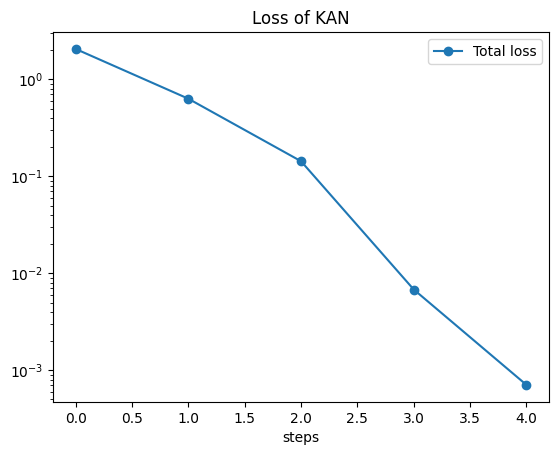

In [6]:
Loss = []
l2_losses = []
writer = SummaryWriter()

def train():
    optimizer = LBFGS(model.parameters(), lr=1e-2,
                      history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    # optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
    
    steps = 5# 20 steps are enough
    pbar = tqdm(range(steps), desc='Training Progress')

    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = pde(coordinates)
            loss.backward()
            return loss

        optimizer.step(closure)
        if step % 2 == 0:
            current_loss = closure().item()
            pbar.set_description("Step: %d | Loss: %.6f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)
        Loss.append(closure().item())
        # l2_losses.append(l2.detach().numpy())
        # print("Current Loss: ",Loss[step])

train()
writer.close()
print(Loss)
plt.plot(Loss, marker='o')
plt.plot(l2_losses, marker='o')
plt.yscale('log')
plt.xlabel('steps')
plt.legend(['Total loss'])
plt.title('Loss of KAN') 

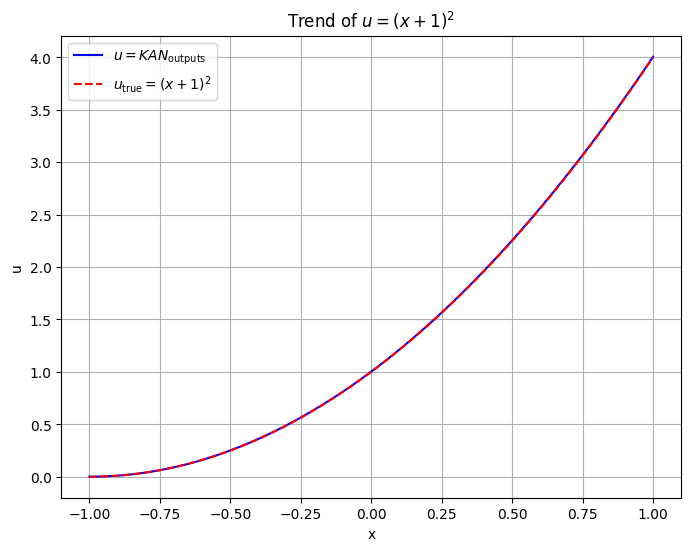

In [7]:
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 256)
result = model(coordinates).cpu().data.numpy()
# 定义真解u_true
u_true = (x+1) ** 2

plt.figure(figsize=(8, 6))
plt.plot(x, result, label=r'$u = KAN_{\text{outputs}}$', color='b')
plt.plot(x, u_true, label=r'$u_{\text{true}} = (x + 1)^2$', color='r', linestyle='--')
plt.title('Trend of $u = (x + 1)^2$')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.show()